# Lab Vision Sytems: Session 8

# Today:

### 1: Solution Assignment 6
### 2: Semantic Segmentation
### 3: Lab Project

# 1: Solution Assignment 6

By Abdul, Hammad, and Doha

# 2: Semantic Segmentation

In [1]:
import os
import math
from tqdm import tqdm
import datetime
import torch
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
import visualizations as visualizations

## Pascal VOC Dataset

In [3]:
img_transforms = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
lbl_transforms = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor()
    ])

In [4]:
train_db = datasets.VOCSegmentation(
        root="data",
        year="2012",
        image_set="train",
        download=True,
        transform=img_transforms,
        target_transform=lbl_transforms
    )
val_db = datasets.VOCSegmentation(
        root="data",
        year="2012",
        image_set="val",
        download=True,
        transform=img_transforms,
        target_transform=lbl_transforms
    )

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [5]:
train_loader = torch.utils.data.DataLoader(
        train_db,
        batch_size=16,
        shuffle=True, 
        num_workers=4
    )
val_loader = torch.utils.data.DataLoader(
        val_db,
        batch_size=1,
        shuffle=False,
        num_workers=4
    )

In [8]:
imgs, lbls = next(iter(train_loader))

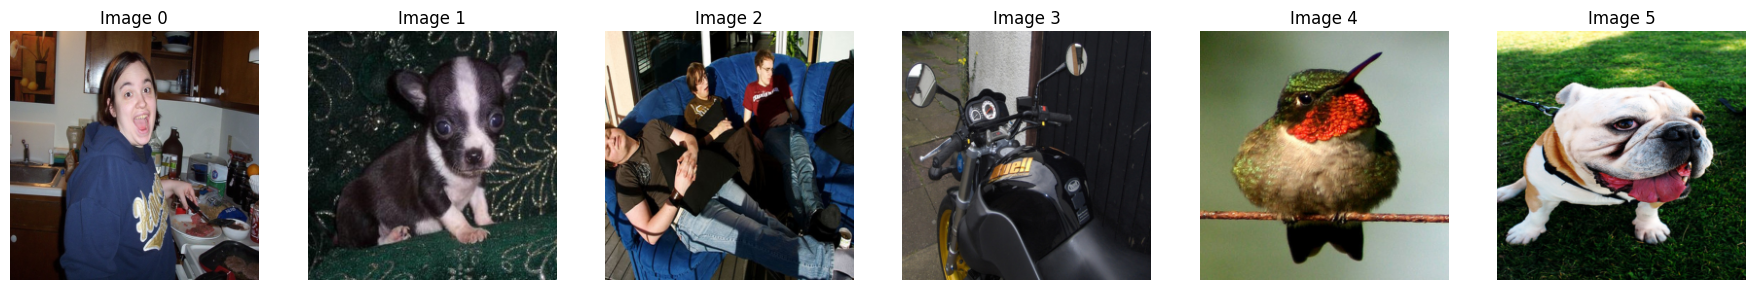

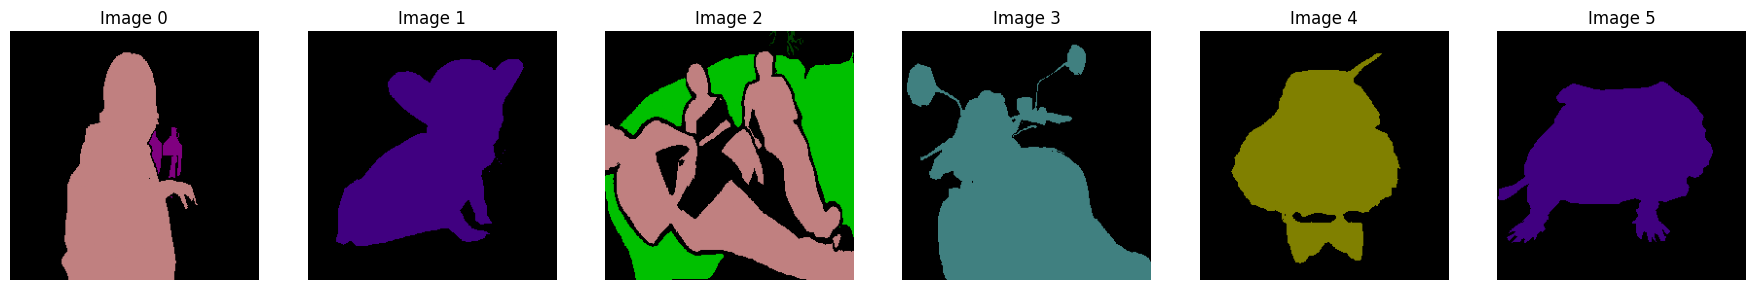

In [10]:
lbls_vis = (lbls * 255).long()
lbls_vis[lbls_vis == 255] = 0
lbls_vis = visualizations.overlay_segmentations(
        frames=imgs,
        segmentations=lbls_vis,
        colors=visualizations.VOC_COLORMAP,
        num_classes=21,
        alpha=1
    )

_ = visualizations.visualize_sequence(imgs[:6], n_cols=6, unnorm=True)
_ = visualizations.visualize_sequence(lbls_vis[:6], n_cols=6)

# Model: Segnet-Like Model

In [11]:
import torch.nn as nn
from torchvision.models import resnet18, resnet34

In [12]:
class Backbone(nn.Module):
    """
    Encoder backbone, which is a modified ResNet18
    """
    
    def __init__(self, pretrained=True, backbone=resnet18):
        """ Module initializer """
        super().__init__()
        self.backbone = backbone(pretrained=pretrained)
        self.backbone.avgpool = nn.Identity()
        self.backbone.fc = nn.Identity()
    
    def forward(self, x):
        """ Forward pass through all blocks, keeping all intermediate representations """
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x0 = x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x1 = x = self.backbone.layer1(x)
        x2 = x = self.backbone.layer2(x)
        x3 = x = self.backbone.layer3(x)
        x4 = x = self.backbone.layer4(x)
        return x0, x1, x2, x3, x4

In [13]:
class DecoderBlock(nn.Module):
    """
    Simple decoder block, which upsamples via a transposed convolution
    """
    
    def __init__(self, in_channels, out_channels, upsampling=2):
        """ """
        super().__init__()
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=upsampling, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )
        return
        
    def forward(self, x):
        """ """
        y = self.decoder(x)
        return y

In [14]:
class SegModel(nn.Module):
    """
    Simple implementation of an FCN-ish module using a ResNet-18 encoder
    """
    
    def __init__(self, num_classes=21, pretrained=True, backbone=resnet18):
        """ """
        super().__init__()
        self.encoder = Backbone(pretrained=True, backbone=backbone)
        
        self.out_conv_4 = DecoderBlock(in_channels=512, out_channels=256, upsampling=2)
        self.out_conv_3 = DecoderBlock(in_channels=256, out_channels=128, upsampling=2)
        self.out_conv_2 = DecoderBlock(in_channels=128, out_channels=64, upsampling=2)
        self.out_conv_1 = DecoderBlock(in_channels=64, out_channels=64, upsampling=2)
        self.out_conv_0 = DecoderBlock(in_channels=64, out_channels=64, upsampling=2)
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=5, padding=2)
        return
    
        
    def forward(self, x):
        """ Forward pass """
        x0, x1, x2, x3, x4 = self.encoder(x)
        y4 = self.out_conv_4(x4)
        y3 = self.out_conv_3(y4 + x3)
        y2 = self.out_conv_2(y3 + x2)
        y1 = self.out_conv_1(y2 + x1)
        y = self.out_conv_0(y1 + x0)
        y = self.final_conv(y)
        return y
    
    def freeze_encoder(self):
        """ """
        for param in self.encoder.parameters():
            param.requires_grad = False
        
    def unfreeze_encoder(self):
        """ """
        for param in self.encoder.parameters():
            param.requires_grad = True

In [15]:
model = SegModel(num_classes=21, backbone=resnet34)

In [16]:
print(imgs.shape)
x = model(imgs)
print(x.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 21, 256, 256])


## Utils

In [17]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    create_dir("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

def create_dir(path):
    """ Creating directory if it does not exist already """
    if not os.path.exists(path):
        os.makedirs(path)
    return

def timestamp():
    """
    Obtaining the current timestamp in an human-readable way
    """
    timestamp = str(datetime.datetime.now()).split('.')[0].replace(' ', '_').replace(':', '-')
    return timestamp

In [18]:
def IoU(pred, target, num_classes):
    """ Computing the IoU for a single image """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for lbl in range(num_classes):
        pred_inds = pred == lbl
        target_inds = target == lbl
        
        intersection = (pred_inds[target_inds]).long().sum().cpu()
        union = pred_inds.long().sum().cpu() + target_inds.long().sum().cpu() - intersection
        iou = intersection / (union + 1e-8)
        iou = iou + 1e-8 if union > 1e-8 and not math.isnan(iou) else 0
        ious.append(iou)
    return torch.tensor(ious)

## Training and Evaluation

In [19]:
def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, tboard=None, start_epoch=0):
    """
    Training a model for a given number of epochs
    """
    
    for epoch in range(num_epochs):       
        # validation epoch
        model.eval()  # important for dropout and batch norms
        loss, (mAcc, mIoU) = eval_model(
                model=model,
                eval_loader=valid_loader,
                criterion=criterion,
                device=device,
                epoch=epoch + start_epoch,
                writer=writer
            )
        writer.add_scalar(f'Metrics/Valid mAcc', mAcc, global_step=epoch+start_epoch)
        writer.add_scalar(f'Metrics/Valid mIoU', mIoU, global_step=epoch+start_epoch)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model,
                train_loader=train_loader,
                optimizer=optimizer,
                criterion=criterion,
                epoch=epoch + start_epoch,
                device=device,
                writer=writer
            )
        scheduler.step(loss)
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)
        writer.add_scalars(
                f'Loss/Combined',
                {"train_loss": mean_loss, "valid_loss": loss},
                global_step=epoch+start_epoch
            )
            
        if epoch % 3 == 0:
            save_model(model, optimizer, epoch + start_epoch, stats={})
        
    print(f"Training completed")
    return

In [20]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device, writer):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = (labels * 255).long().to(device)
        labels[labels == 255] = 0
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels[:, 0])
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        if i % 30 == 0:
            iter_ = epoch * len(train_loader) + i
            lr = optimizer.param_groups[0]['lr']
            writer.add_scalar(f'Loss/Train Iters', loss.item(), global_step=iter_)
            writer.add_scalar(f'_Params/Learning Rate', lr, global_step=iter_)
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list

In [21]:
@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch, writer):
    """ Evaluating the model for either validation or test """
    correct_pixels = 0
    total_pixels = 0
    ious = []
    loss_list = []
    
    for images, labels in tqdm(eval_loader):
        images = images.to(device)
        labels = (labels * 255).long().to(device)
        labels[labels == 255] = 0
        
        # Forward pass only to get logits/output
        outputs = model(images)    
        loss = criterion(outputs, labels[:, 0])
        loss_list.append(loss.item())
            
        # computing evaluation metrics
        predicted_class = torch.argmax(outputs, dim=1)
        correct_pixels += predicted_class.eq(labels).sum().item()
        total_pixels += labels.numel()
        iou = IoU(predicted_class, labels, num_classes=outputs.shape[1])
        ious.append(iou)
    
    # mean metrics and loss
    loss = np.mean(loss_list)
    avg_accuracy = 100 * correct_pixels / total_pixels   
    ious = torch.stack(ious)
    ious = ious.sum(dim=-1) / (ious != 0).sum(dim=-1)  # per class IoU
    mIoU = ious.mean()  # averaging across classes
    
    # creating a visualization for tensorboard
    add_visualization(model, eval_loader, epoch, writer)
    
    return loss, (avg_accuracy, mIoU)


@torch.no_grad()
def add_visualization(model, eval_loader, epoch, writer,):
    """ """
    imgs, lbls, preds = [], [], []
    for i, (img, lbl) in enumerate(eval_loader):
        img = img.to(device)
        lbl[lbl == 255] = 0

        outputs = model(img)   
        predicted_class = torch.argmax(outputs, dim=1)
        
        imgs.append(img.cpu())
        lbls.append(lbl.cpu())
        preds.append(predicted_class.cpu())
    imgs = torch.cat(imgs, dim=0)
    lbls = torch.cat(lbls, dim=0)
    preds = torch.stack(preds, dim=0)

    fig, ax = qualitative_evaluation(imgs, lbls, preds)
    writer.add_figure("Qualitative Eval", fig, global_step=epoch)
    return

## Training

In [22]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [23]:
model = SegModel(num_classes=21, backbone=resnet34)

In [24]:
weights = torch.ones(21, device=device)
# weights[0] = 0.1

In [25]:
# classification loss function
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=255)  # Important to ignore 255

# Adam Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)

In [26]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", timestamp())
create_dir(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

In [27]:
# model.freeze_encoder()
# train_model(
#         model=model,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         criterion=criterion,
#         train_loader=train_loader,
#         valid_loader=val_loader,
#         num_epochs=25,
#         tboard=writer,
#         start_epoch=0
#     )

In [28]:
# Lowering learning rate and unfreezing encoder
# model.unfreeze_encoder()
# for g in optimizer.param_groups:
#     g['lr'] *= 0.5

In [29]:
# further fine-tuning with unfrozen encoder
# train_model(
#         model=model,
#         optimizer=optimizer,
#         scheduler=scheduler,
#         criterion=criterion,
#         train_loader=train_loader,
#         valid_loader=val_loader,
#         num_epochs=50,
#         tboard=writer,
#         start_epoch=25
#     )

## Visualizations

In [30]:
model, optimizer, epoch, stats = load_model(
        model,
        optimizer,
        savepath=os.path.join(os.getcwd(), "checkpoints", "checkpoint_epoch_70.pth")
    )
model = model.cpu()

In [31]:
model = model.eval()

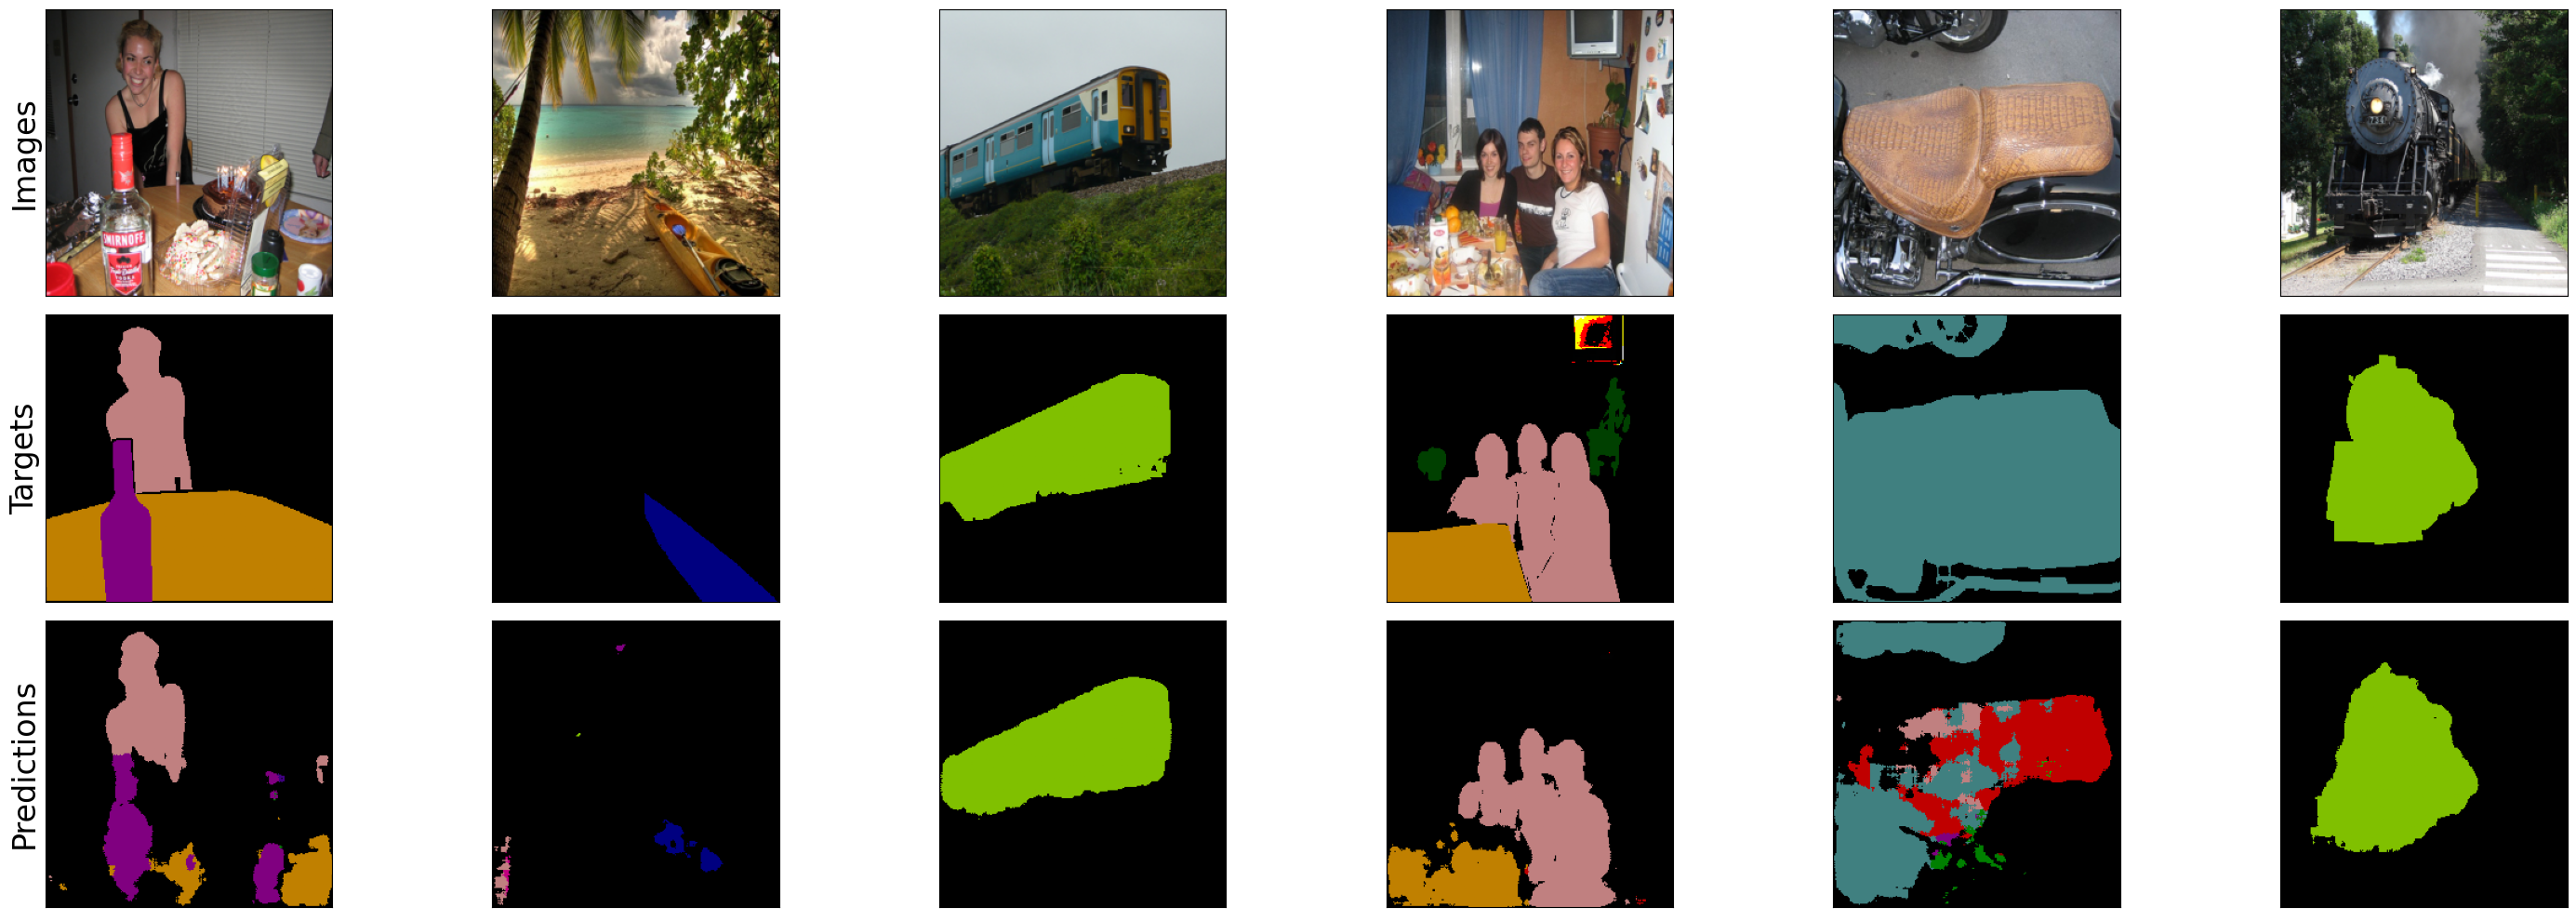

In [33]:
import numpy as np
idx = np.random.randint(0, 1000, 6)

imgs = torch.stack([val_db[i][0] for i in idx])
lbls = torch.stack([val_db[i][1] for i in idx])
lbls[lbls*255 == 255] = 0

outputs = model(imgs)   
preds = torch.argmax(outputs, dim=1).unsqueeze(1)

fig, ax = visualizations.qualitative_evaluation(imgs, lbls, preds)

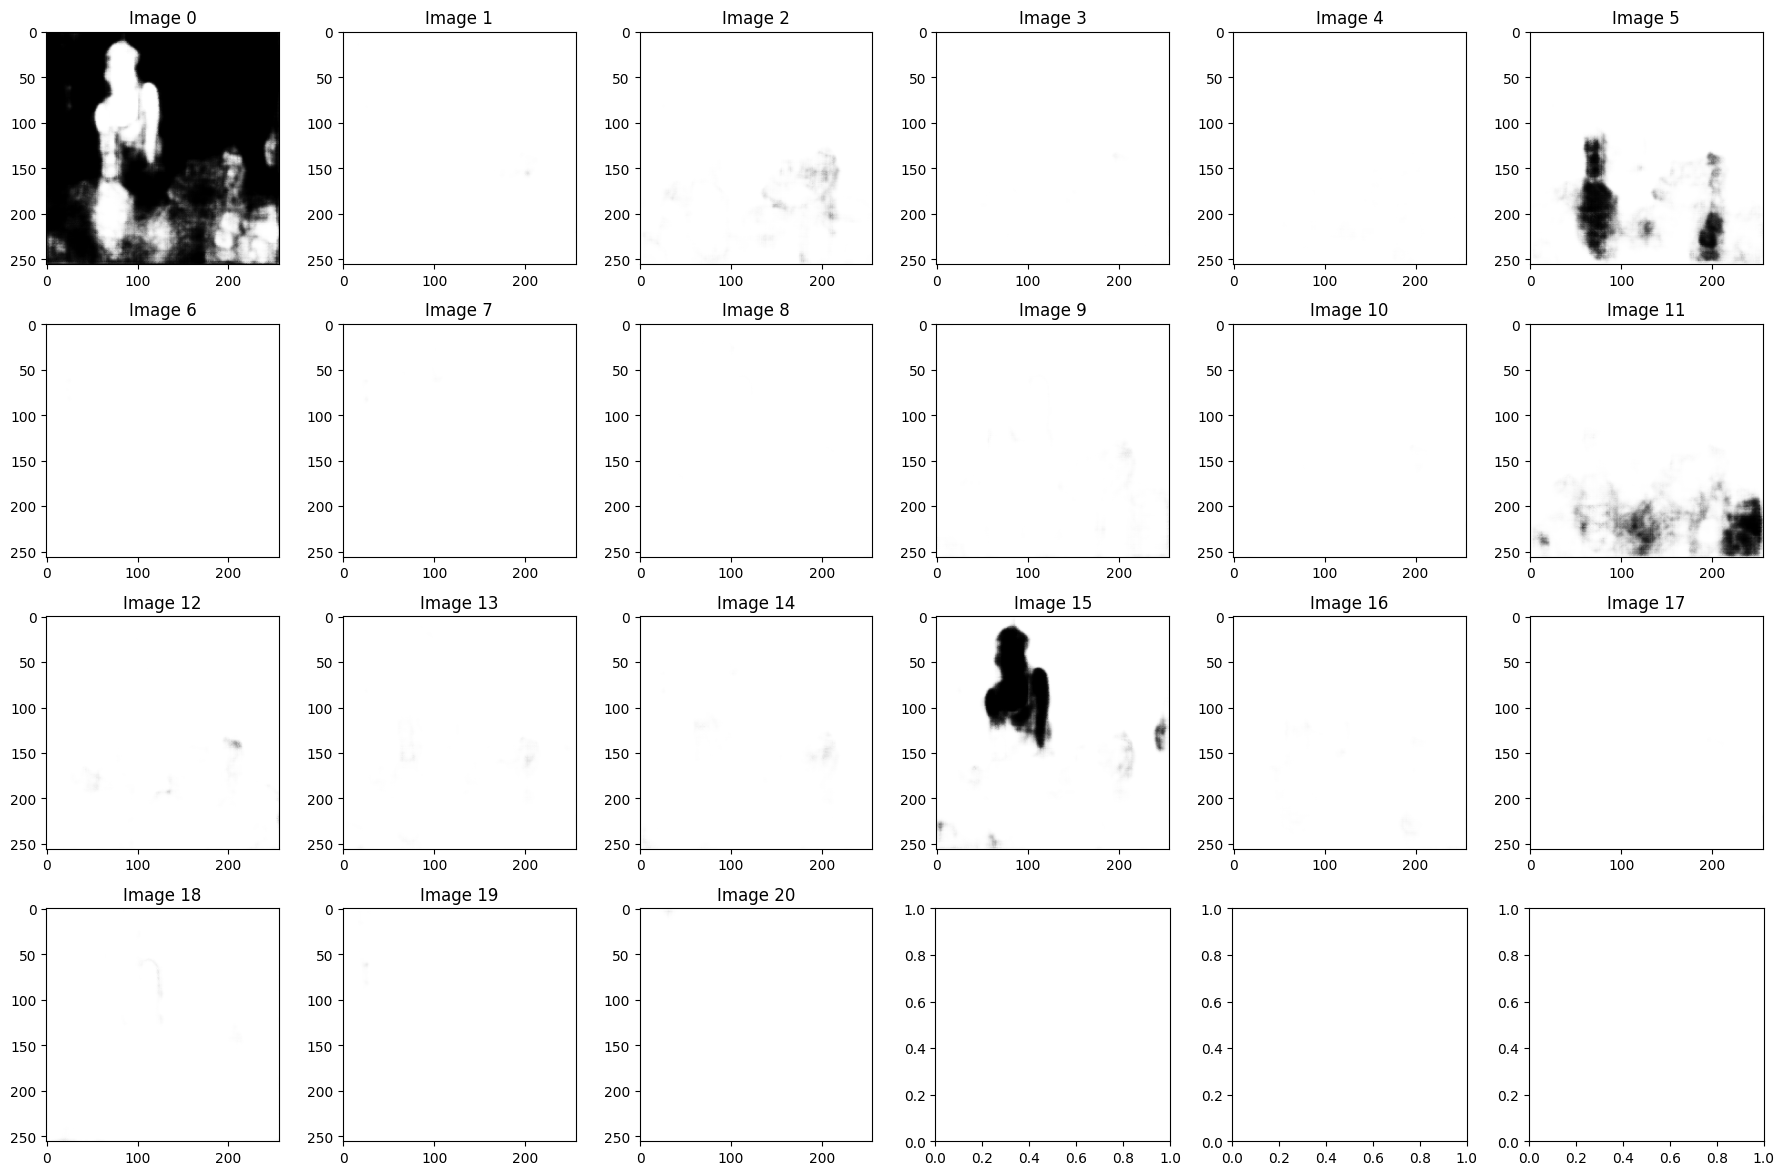

In [34]:
y = nn.Softmax(dim=0)(outputs[0]).unsqueeze(1)
_ = visualizations.visualize_sequence(y, n_cols=6, n_channels=1, vmin=0, vmax=1, cmap="gray_r", add_axis=True)

# Assignment 8

#### **Note:** The CudaLab project is an extension of this assignment. I recommend reaching a good solution in this assignment,and then extend the model as required in the project.

 - Implement a UNet model:
    - Choose your own encoder and decoder
    - Residual connections
 - Train your model on the Cityscapes dataset
    - Autonomous driving scenes
    - Not too much data:
      - Data augmentation
      - Transfer learning
      - Loss weighting
      - ...  
 - Evaluate your model using Accuracy, mIoU and Dice Coefficient
 - Show some images and the results
 - Which classes are the most problematic?
 - **Extra Point**: Train the same model as before, but with the following loss functions, and compare the results:
     - Dice Loss
     - Focal Loss

# 3: CudaLab Project

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  